# Predicting customer churn (attrition)

### By: Raphael Rivers

# Feature Engineering - Cluster Analysis

In [1]:
# Import all modules and read in the dataset
from modules import*

In [2]:
# Extract numeric columns and force hard copy
df_clust = churn_df.copy()
numeric_vars = df_clust.select_dtypes('number').copy()
numeric_vars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   account_length                 5000 non-null   int64  
 1   number_vmail_messages          5000 non-null   int64  
 2   total_day_minutes              5000 non-null   float64
 3   total_day_calls                5000 non-null   int64  
 4   total_day_charge               5000 non-null   float64
 5   total_eve_minutes              5000 non-null   float64
 6   total_eve_calls                5000 non-null   int64  
 7   total_eve_charge               5000 non-null   float64
 8   total_night_minutes            5000 non-null   float64
 9   total_night_calls              5000 non-null   int64  
 10  total_night_charge             5000 non-null   float64
 11  total_intl_minutes             5000 non-null   float64
 12  total_intl_calls               5000 non-null   i

### Standardize Variables
Let's standardize the variables and determine the optimal number of clusters using the knee bend method

In [3]:
# Initialize standard scaler
scaler = StandardScaler()

In [4]:
# fit the scaler
Xchurn = scaler.fit_transform(numeric_vars)

In [5]:
# store transformed numeric variable for reuse
%store Xchurn

Stored 'Xchurn' (ndarray)


In [6]:
# Convert the returned NumPy array into a DataFrame to support visualizing with Seaborn
Xchurn_df = pd.DataFrame(Xchurn, columns=numeric_vars.columns)

### Determine Opitmal Number of Clusters

In [7]:
# Fit and predict using Kmeans using 4 clusters
km = KMeans(n_clusters=4, random_state=121, n_init=25, max_iter=500).fit_predict(Xchurn)

In [8]:
# Assign the CLUSTER LABELS to the copied DataFrame
Xchurn_df['clusters'] = pd.Series( km, index=df_clust.index ).astype('category')

In [9]:
# # Determine the optimal number of clusters using the knee bend method
tots_within_ss = []
K = range(1, 50)
for k in K:
    kms = KMeans(n_clusters=k, random_state=121, n_init=25, max_iter=500)
    kms = kms.fit( Xchurn )
    tots_within_ss.append( kms.inertia_ ) # Inertia attributes calculates the Total Within Sum of Squares

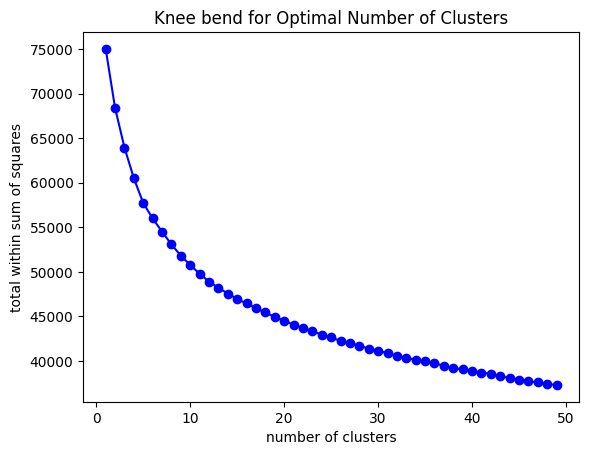

In [10]:
# Visualize Knee bend plot
fig, ax = plt.subplots()

ax.plot( K, tots_within_ss, 'bo-' )
ax.set_title('Knee bend for Optimal Number of Clusters')
ax.set_xlabel('number of clusters')
ax.set_ylabel('total within sum of squares')

plt.show()

### PCA Clustering
Clustering using 4 clusters based off the result of the kneebend visualization

In [11]:
# Select 4 clusters at the knee bend point
optimal_clusters = 4

# Apply KMeans clustering
kmeans = KMeans(n_clusters=optimal_clusters, random_state=121)
cluster_labels = kmeans.fit_predict(numeric_vars)


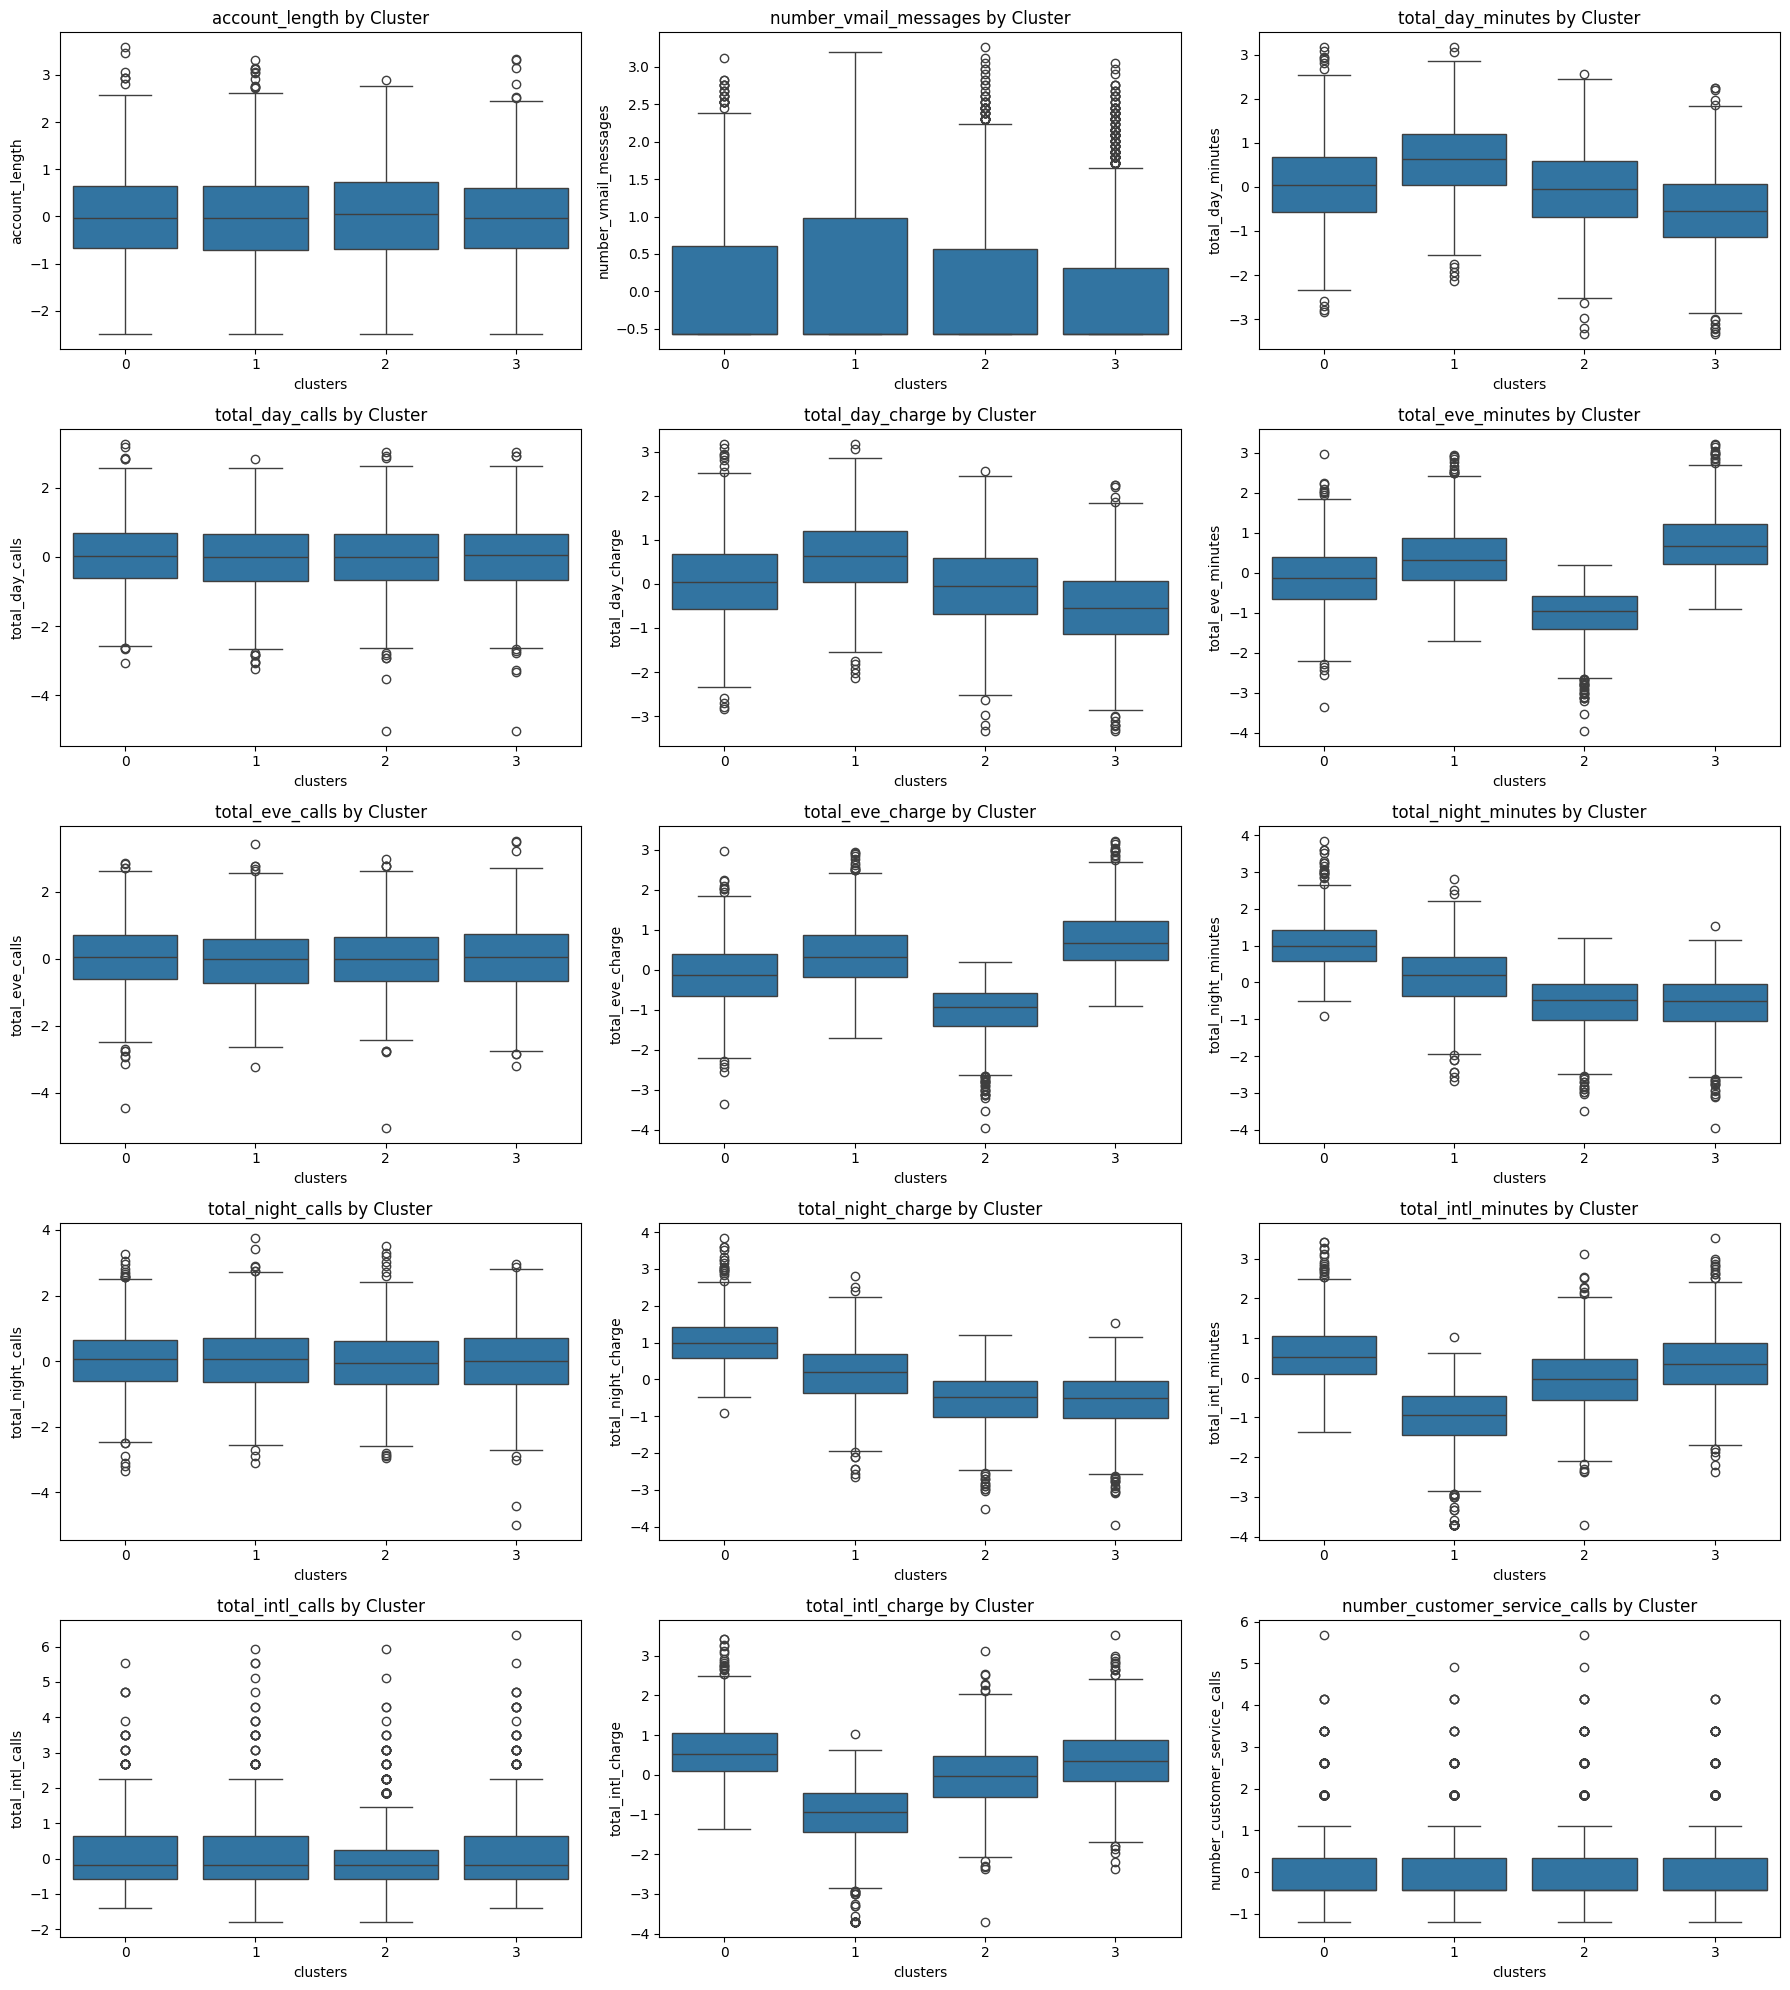

In [12]:
# Visualize the cluster assignments
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18, 20))
for i, col in enumerate(numeric_vars):
    ax = axes[i // 3, i % 3]
    sns.boxplot(data=Xchurn_df, x='clusters', y=col, ax=ax)
    ax.set_title(f'{col} by Cluster')

plt.tight_layout()
plt.show()

In [13]:
# Perform PCA Reduce to 2 principal components for visualization
pca = PCA(n_components=2)  
pca_scores = pca.fit_transform(Xchurn)

In [14]:
# Apply KMeans clustering on the PCA scores
kmeans_pca = KMeans(n_clusters=optimal_clusters, random_state=121)
pca_cluster_labels = kmeans_pca.fit_predict(pca_scores)

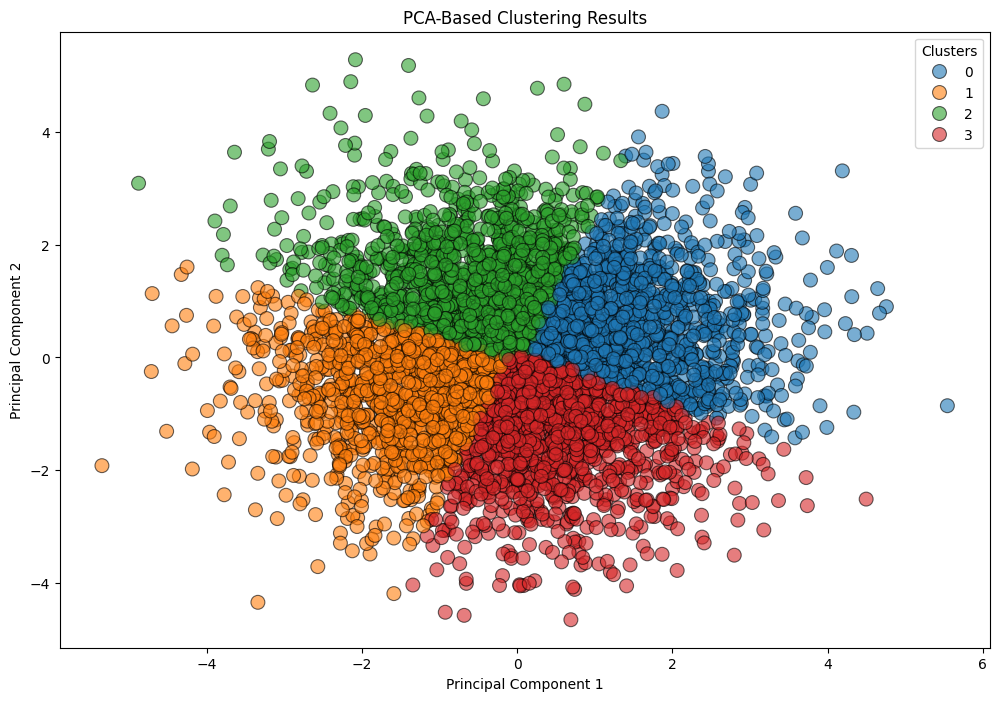

In [15]:
# Visualize the PCA-based clustering results
plt.figure(figsize=(12, 8))
sns.scatterplot(x=pca_scores[:, 0], y=pca_scores[:, 1], hue=pca_cluster_labels, palette='tab10', s=100, alpha=0.6, edgecolor='k')
plt.title('PCA-Based Clustering Results')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Clusters')
plt.show()

### PCA Loadings Analysis
Let’s calculate and analyze the PCA loadings to determine the most important variables.

In [16]:
# Get the PCA loadings values
pc_loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=numeric_vars.columns)

In [17]:
# PC1 Sort from the highest values 
pc_loadings.sort_values(by='PC1', ascending=False)

,PC1,PC2
total_intl_minutes,0.316688,-0.451878
total_intl_charge,0.316646,-0.451872
total_eve_charge,0.313427,0.420108
total_eve_minutes,0.313421,0.420106
total_intl_calls,0.027860,0.000231
number_vmail_messages,0.005148,0.013355
total_day_calls,0.004343,-0.013270
account_length,-0.004092,-0.010362
total_eve_calls,-0.010043,0.011347
number_customer_service_calls,-0.012080,0.005230


### PC1 (Principal Component 1):

The variables `total_intl_minutes`, `total_intl_charge`, `total_eve_charge`, and `total_eve_minutes` have high positive loadings on PC1. These variables are crucial in capturing the primary variance in the data. This suggests that international call usage and voicemail messages add another a dimension of variance, differentiating customer behavior.

In [18]:
# PC2 Sort front the higest values
pc_loadings.sort_values(by='PC2', ascending=False)

,PC1,PC2
total_eve_charge,0.313427,0.420108
total_eve_minutes,0.313421,0.420106
total_day_charge,-0.408203,0.214441
total_day_minutes,-0.408201,0.214439
number_vmail_messages,0.005148,0.013355
total_eve_calls,-0.010043,0.011347
number_customer_service_calls,-0.012080,0.005230
total_intl_calls,0.027860,0.000231
total_night_calls,-0.013402,-0.001773
account_length,-0.004092,-0.010362


### PC2 (Principal Component 2):

The variables `total_eve_charge	`, `total_eve_minutes`, `total_day_charge`, and `total_day_minutes` have significant loadings on PC2.  This indicates that the overall usage of evening minutes and charges across different times is a significant factor differentiating all the clusters not just the one captured by PC1 alone.

**Combined Importance:** The variables with high loadings on both PC1 and PC2 are especially important. For example, `total_eve_minutes` and `total_eve_minutes` are critical for both PC1, and PC2.

Also variables like `number_customer_service_calls_log` which shows similar variance in both PCs, contribute moderately to both components, indicating their relevance in explaining variations in customer behavior.

Overall, the most important variables identified through PCA are those related to usage and charges across different time periods, as well as international call metrics and customer service interactions. These variables are key in differentiating customer segments and understanding their behavior, which can inform targeted marketing and service strategies.